In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../'))

In [3]:
from copy import deepcopy
from tqdm import tqdm

import torch
from torch import optim
from IPython.display import clear_output

seed = 42
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from model import DiffusionModel
from training import get_config, ImgDataset, ema_update, demo
from diffusion import diffusion_loss

import utils

In [5]:
# Define dataset.
dataset_name = 'cifar_10'
# dataset_name = 'svhn'
# dataset_name = 'fashion_mnist'
# dataset_name = 'mnist'
# dataset_name = 'chars74k_fnt_num'

save_dir = os.path.join('./output/diffusion_cen', dataset_name)
os.makedirs(save_dir, exist_ok=True)

In [6]:
data_config, train_config = get_config(dataset_name)
print(data_config)
print(train_config)

# Data config.
# img_size = data_config['img_size']
channels = data_config['channels']
batch_size = data_config['batch_size']
train_transform = data_config['train_transform']
test_transform = data_config['test_transform']

# Training config.
lr = train_config['lr']
timesteps = train_config['timesteps']
num_epochs = train_config['epochs']
ema_decay = train_config['ema_decay']
eta = train_config['eta']
save_interval = train_config['save_interval']

{'img_size': 32, 'channels': 3, 'batch_size': 512, 'train_transform': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
    Normalize(mean=[0.5], std=[0.5])
), 'test_transform': Compose(
    ToTensor()
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
    Normalize(mean=[0.5], std=[0.5])
)}
{'lr': 0.0002, 'timesteps': 300, 'epochs': 10000, 'rounds': 300, 'local_epochs': 3, 'ema_decay': 0.998, 'eta': 1.0, 'save_interval': 1000}


In [7]:
# Data.
data_dir = os.path.join('../datasets/', dataset_name)

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_data = ImgDataset(train_dir, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=12, prefetch_factor=12, pin_memory=True, persistent_workers=True)

test_data = ImgDataset(test_dir, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=12, prefetch_factor=12, pin_memory=True, persistent_workers=True)

In [8]:
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as F
# import numpy as np

# def show(imgs):
#     if not isinstance(imgs, list):
#         imgs = [imgs]
#     fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = img.detach()
#         img = F.to_pil_image(img)
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
# img = test_data[1000][0]
# show(img)

In [9]:
# Initialize model.
model = DiffusionModel().to(device)
model_ema = deepcopy(model)
optimizer = optim.Adam(model.parameters(), lr=lr)
grad_scaler = torch.cuda.amp.GradScaler()

In [10]:
# For logging model performance.
metric_keys = ['train_loss', 'test_loss']
performance_dict, performance_log = utils.get_performance_loggers(metric_keys)

In [11]:
# Automatic resuming from checkpoint.
log_path = os.path.join(save_dir, 'performance_log.pickle')
if os.path.isfile(log_path):
    performance_log = utils.load_pickle(log_path)
start_epoch = len(performance_log[metric_keys[0]])

ckpt_path = os.path.join(save_dir, 'ckpt_bundle.pth')
if start_epoch > 0:
    ckpt_bundle = torch.load(ckpt_path)
    model.load_state_dict(ckpt_bundle['model'])
    model_ema.load_state_dict(ckpt_bundle['model_ema'])
    optimizer.load_state_dict(ckpt_bundle['optimizer'])
    grad_scaler.load_state_dict(ckpt_bundle['grad_scaler'])


 ==================== Epoch: 9001 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03181296702930514
test_loss :  0.03287746524438262

 ==================== Epoch: 9002 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031904835310973684
test_loss :  0.032880802918225524

 ==================== Epoch: 9003 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.0318963760510087
test_loss :  0.03291230155155063

 ==================== Epoch: 9004 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03201080113649368
test_loss :  0.03287392510101199

 ==================== Epoch: 9005 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03195085062892461
test_loss :  0.032847941387444735

 ==================== Epoch: 9006 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031869289997432916
test_loss :  0.032856849301606414

 ==================== Epoch: 9007 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.0318372739783051
test_loss :  0.03286340683698654

 ==================== Epoch: 9008 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03188909713787084
test_loss :  0.032873109355568884

 ==================== Epoch: 9009 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03185848283524416
test_loss :  0.0328633445315063

 ==================== Epoch: 9010 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03196313142852516
test_loss :  0.03288378715515137

 ==================== Epoch: 9011 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03195626619366967
test_loss :  0.03287467798218131

 ==================== Epoch: 9012 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03194449674718234
test_loss :  0.03288957355543971

 ==================== Epoch: 9013 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.032031217856066566
test_loss :  0.03289346359670162

 ==================== Epoch: 9014 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031711120652605077
test_loss :  0.0328465168364346

 ==================== Epoch: 9015 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.032052498177758286
test_loss :  0.032874025963246824

 ==================== Epoch: 9016 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03195236440824003
test_loss :  0.032924795895814894

 ==================== Epoch: 9017 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03195831223333977
test_loss :  0.03287070421501994

 ==================== Epoch: 9018 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.0318698008183618
test_loss :  0.03286760849878192

 ==================== Epoch: 9019 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.0319434859010638
test_loss :  0.03285715570673346

 ==================== Epoch: 9020 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03189984231959192
test_loss :  0.032816559355705974

 ==================== Epoch: 9021 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031868741011285055
test_loss :  0.03286418179050088

 ==================== Epoch: 9022 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.0319133639259606
test_loss :  0.03287390870973468

 ==================== Epoch: 9023 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03180617877111143
test_loss :  0.03284510569646955

 ==================== Epoch: 9024 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03190894035280359
test_loss :  0.03286590129137039

 ==================== Epoch: 9025 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03185734945368402
test_loss :  0.032869113702327014

 ==================== Epoch: 9026 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03186533955515039
test_loss :  0.03285761550068855

 ==================== Epoch: 9027 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03195111618890446
test_loss :  0.03287057913839817

 ==================== Epoch: 9028 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03176118408766936
test_loss :  0.03288194835186005

 ==================== Epoch: 9029 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031702254157589406
test_loss :  0.03282734407112002

 ==================== Epoch: 9030 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031928966335039964
test_loss :  0.03283712100237608

 ==================== Epoch: 9031 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.032002822762089114
test_loss :  0.03283725474029779

 ==================== Epoch: 9032 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.032036121231408754
test_loss :  0.03287373399361968

 ==================== Epoch: 9033 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03190741815357184
test_loss :  0.03288741046562791

 ==================== Epoch: 9034 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03193730091181945
test_loss :  0.03286693701520562

 ==================== Epoch: 9035 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03196033751782106
test_loss :  0.0328405387699604

 ==================== Epoch: 9036 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03189740463026932
test_loss :  0.03286905372515321

 ==================== Epoch: 9037 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.032118002751043866
test_loss :  0.032822906691581014

 ==================== Epoch: 9038 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03186187547232423
test_loss :  0.032822821475565436

 ==================== Epoch: 9039 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03187251148023167
test_loss :  0.03287927089259028

 ==================== Epoch: 9040 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031899098801065465
test_loss :  0.032855328638106585

 ==================== Epoch: 9041 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.0319885804070806
test_loss :  0.03285746667534113

 ==================== Epoch: 9042 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031906905831122885
test_loss :  0.032857108488678934

 ==================== Epoch: 9043 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.0319352584263804
test_loss :  0.03287228550761938

 ==================== Epoch: 9044 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03186822956313892
test_loss :  0.03286411594599485

 ==================== Epoch: 9045 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.032059657159356436
test_loss :  0.03285060925409198

 ==================== Epoch: 9046 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03184152567493064
test_loss :  0.03285709405317903

 ==================== Epoch: 9047 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031827493969883235
test_loss :  0.03285082001239061

 ==================== Epoch: 9048 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03188454120286873
test_loss :  0.03286713240668178

 ==================== Epoch: 9049 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.032122350582967
test_loss :  0.03285201387479901

 ==================== Epoch: 9050 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031931547676118055
test_loss :  0.032873671036213636

 ==================== Epoch: 9051 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.0319305421518428
test_loss :  0.03285247376188636

 ==================== Epoch: 9052 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031949669141702504
test_loss :  0.03285795692354441

 ==================== Epoch: 9053 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03196492496573804
test_loss :  0.03289554063230753

 ==================== Epoch: 9054 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03191465036753489
test_loss :  0.03288638470694423

 ==================== Epoch: 9055 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031974837944215656
test_loss :  0.032870481722056866

 ==================== Epoch: 9056 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03193149219590182
test_loss :  0.03285930473357439

 ==================== Epoch: 9057 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03175594093164011
test_loss :  0.032878319080919025

 ==================== Epoch: 9058 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031989570498010336
test_loss :  0.03284125383943319

 ==================== Epoch: 9059 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03180702621763458
test_loss :  0.032853150926530364

 ==================== Epoch: 9060 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03200663149128763
test_loss :  0.03287515770643949

 ==================== Epoch: 9061 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03190685147229506
test_loss :  0.03283938961103559

 ==================== Epoch: 9062 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03197444718787257
test_loss :  0.032867596857249735

 ==================== Epoch: 9063 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03187606679465698
test_loss :  0.03289325181394816

 ==================== Epoch: 9064 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03200347029737064
test_loss :  0.03285464625805616

 ==================== Epoch: 9065 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03193924866844805
test_loss :  0.03289452148601413

 ==================== Epoch: 9066 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03188422215836389
test_loss :  0.032861773110926154

 ==================== Epoch: 9067 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03186951448418656
test_loss :  0.0328789945691824

 ==================== Epoch: 9068 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03201137437504165
test_loss :  0.03289135666564107

 ==================== Epoch: 9069 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03192963593696453
test_loss :  0.03289746474474668

 ==================== Epoch: 9070 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031880669846978724
test_loss :  0.03285686848685145

 ==================== Epoch: 9071 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.031930060391979556
test_loss :  0.03287207949906588

 ==================== Epoch: 9072 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03193755499182307
test_loss :  0.032856644690036775

 ==================== Epoch: 9073 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03199754915751365
test_loss :  0.03285472774878144

 ==================== Epoch: 9074 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03207427894278449
test_loss :  0.0328718994744122

 ==================== Epoch: 9075 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03202422050645157
test_loss :  0.03287294041365385

 ==================== Epoch: 9076 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.0319023547237929
test_loss :  0.03283819034695625

 ==================== Epoch: 9077 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.51it/s]


train_loss :  0.0319307340803195
test_loss :  0.032886074483394624

 ==================== Epoch: 9078 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03199536771494515
test_loss :  0.0328854407183826

 ==================== Epoch: 9079 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.032071340030857494
test_loss :  0.032921455428004266

 ==================== Epoch: 9080 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03194812154967566
test_loss :  0.03286057868972421

 ==================== Epoch: 9081 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.0317722711027885
test_loss :  0.03283730838447809

 ==================== Epoch: 9082 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.38it/s]


train_loss :  0.03191722317465714
test_loss :  0.032886172737926246

 ==================== Epoch: 9083 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.031947494180378865
test_loss :  0.03289272543042898

 ==================== Epoch: 9084 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.032019387075335394
test_loss :  0.03286860575899482

 ==================== Epoch: 9085 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03182166786294202
test_loss :  0.032877654395997526

 ==================== Epoch: 9086 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03195652933981346
test_loss :  0.03290551109239459

 ==================== Epoch: 9087 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.0321077471408917
test_loss :  0.032895279210060836

 ==================== Epoch: 9088 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03191926830201125
test_loss :  0.032859706319868565

 ==================== Epoch: 9089 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03181317102696214
test_loss :  0.03287547789514065

 ==================== Epoch: 9090 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03181676631223182
test_loss :  0.03285020962357521

 ==================== Epoch: 9091 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03193137779527781
test_loss :  0.03286601100116968

 ==================== Epoch: 9092 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03187143785536897
test_loss :  0.0328330734744668

 ==================== Epoch: 9093 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031877425252174844
test_loss :  0.03283869195729494

 ==================== Epoch: 9094 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03198919916639523
test_loss :  0.03285984834656119

 ==================== Epoch: 9095 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03187409666728
test_loss :  0.03285988355055451

 ==================== Epoch: 9096 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03190702382399111
test_loss :  0.032841083314269784

 ==================== Epoch: 9097 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031859551214289905
test_loss :  0.03287969827651978

 ==================== Epoch: 9098 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03184609710029802
test_loss :  0.03286813348531723

 ==================== Epoch: 9099 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03194133475498886
test_loss :  0.032842705491930246

 ==================== Epoch: 9100 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.0319838833101854
test_loss :  0.03286329759284854

 ==================== Epoch: 9101 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03183420213433553
test_loss :  0.032844905834645034

 ==================== Epoch: 9102 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03191086706914464
test_loss :  0.03288155375048518

 ==================== Epoch: 9103 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03183591764952455
test_loss :  0.03288985276594758

 ==================== Epoch: 9104 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03189273355338646
test_loss :  0.03286787467077375

 ==================== Epoch: 9105 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03191788496487603
test_loss :  0.032850036211311814

 ==================== Epoch: 9106 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03180433764141433
test_loss :  0.03287219600751996

 ==================== Epoch: 9107 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03197782507584411
test_loss :  0.0329142183996737

 ==================== Epoch: 9108 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03202255235566777
test_loss :  0.032871124893426897

 ==================== Epoch: 9109 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03202914433287723
test_loss :  0.03283475684002042

 ==================== Epoch: 9110 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031861656459466536
test_loss :  0.032865783851593736

 ==================== Epoch: 9111 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03180226299683658
test_loss :  0.03288006307557225

 ==================== Epoch: 9112 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03190222019519733
test_loss :  0.0328916103579104

 ==================== Epoch: 9113 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03199348155865256
test_loss :  0.03285351451486349

 ==================== Epoch: 9114 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.0321030308663541
test_loss :  0.032891804538667205

 ==================== Epoch: 9115 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.032044688695851635
test_loss :  0.032881103362888096

 ==================== Epoch: 9116 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031950387742598445
test_loss :  0.032862420100718735

 ==================== Epoch: 9117 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031888495332428386
test_loss :  0.03287937343120575

 ==================== Epoch: 9118 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.03199962064699859
test_loss :  0.032863397244364025

 ==================== Epoch: 9119 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03195011283137968
test_loss :  0.032909234426915644

 ==================== Epoch: 9120 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031861018693568756
test_loss :  0.03285412415862084

 ==================== Epoch: 9121 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.032191647197671085
test_loss :  0.03291002884507179

 ==================== Epoch: 9122 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03184426300303669
test_loss :  0.032879948429763314

 ==================== Epoch: 9123 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03181288826602454
test_loss :  0.032850575353950265

 ==================== Epoch: 9124 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03197914371457027
test_loss :  0.032874600403010844

 ==================== Epoch: 9125 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031949978454836776
test_loss :  0.03285311171784997

 ==================== Epoch: 9126 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03189566556592377
test_loss :  0.03287506541237235

 ==================== Epoch: 9127 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03190894504742963
test_loss :  0.03285182127729058

 ==================== Epoch: 9128 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03197637067309448
test_loss :  0.0328533167950809

 ==================== Epoch: 9129 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03190589430076735
test_loss :  0.032863221038132905

 ==================== Epoch: 9130 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031986892432430566
test_loss :  0.032832741644233464

 ==================== Epoch: 9131 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03188023128907899
test_loss :  0.03286809083074331

 ==================== Epoch: 9132 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03177323962124635
test_loss :  0.03288025725632906

 ==================== Epoch: 9133 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03192234753954167
test_loss :  0.032901814114302395

 ==================== Epoch: 9134 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03196278794155437
test_loss :  0.03287357352674007

 ==================== Epoch: 9135 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031881059234847825
test_loss :  0.03283382840454578

 ==================== Epoch: 9136 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03200027209763624
test_loss :  0.03290600711479783

 ==================== Epoch: 9137 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03207358166727484
test_loss :  0.03285804260522127

 ==================== Epoch: 9138 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031932158756773084
test_loss :  0.032858031522482636

 ==================== Epoch: 9139 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03188082879903365
test_loss :  0.03288578437641263

 ==================== Epoch: 9140 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031918883209629934
test_loss :  0.03287112945690751

 ==================== Epoch: 9141 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03188532244946275
test_loss :  0.032872450444847344

 ==================== Epoch: 9142 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03214002377828773
test_loss :  0.03285695863887668

 ==================== Epoch: 9143 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031932552459136565
test_loss :  0.03284450760111213

 ==================== Epoch: 9144 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03187572893363481
test_loss :  0.032906508073210716

 ==================== Epoch: 9145 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03194124340935021
test_loss :  0.03284488031640649

 ==================== Epoch: 9146 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03192542383105171
test_loss :  0.0328993396833539

 ==================== Epoch: 9147 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03213169250865372
test_loss :  0.03286658236756921

 ==================== Epoch: 9148 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03198773138301105
test_loss :  0.032889535184949636

 ==================== Epoch: 9149 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03174260577985218
test_loss :  0.03288407605141401

 ==================== Epoch: 9150 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.0318577270194584
test_loss :  0.03288098191842437

 ==================== Epoch: 9151 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031834347211584756
test_loss :  0.032859823666512966

 ==================== Epoch: 9152 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031961337017009456
test_loss :  0.032862434070557354

 ==================== Epoch: 9153 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03197093625381893
test_loss :  0.03288404354825616

 ==================== Epoch: 9154 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031912157958259385
test_loss :  0.03285993328318

 ==================== Epoch: 9155 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031798498248871494
test_loss :  0.03286607908084989

 ==================== Epoch: 9156 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03198955932213944
test_loss :  0.03284453703090549

 ==================== Epoch: 9157 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03183837330006823
test_loss :  0.032892119605094194

 ==================== Epoch: 9158 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031876669113277176
test_loss :  0.032866083458065985

 ==================== Epoch: 9159 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031868658028542995
test_loss :  0.032857940532267094

 ==================== Epoch: 9160 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031877887568303516
test_loss :  0.03285242039710283

 ==================== Epoch: 9161 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031931178739332426
test_loss :  0.03283866038545966

 ==================== Epoch: 9162 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03203759511590612
test_loss :  0.032864924427121876

 ==================== Epoch: 9163 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03188653731224488
test_loss :  0.03285318110138178

 ==================== Epoch: 9164 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03184644693546757
test_loss :  0.03288336982950568

 ==================== Epoch: 9165 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03183349860566003
test_loss :  0.03287304015830159

 ==================== Epoch: 9166 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03199736127743916
test_loss :  0.03284253478050232

 ==================== Epoch: 9167 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032008805768374275
test_loss :  0.03283586371690035

 ==================== Epoch: 9168 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.38it/s]


train_loss :  0.0319113425948486
test_loss :  0.03288108827546239

 ==================== Epoch: 9169 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03179333623194573
test_loss :  0.03288099393248558

 ==================== Epoch: 9170 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031854613893190206
test_loss :  0.03288757838308811

 ==================== Epoch: 9171 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03209547504630624
test_loss :  0.03286739895120263

 ==================== Epoch: 9172 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031843093927113375
test_loss :  0.03289246475324035

 ==================== Epoch: 9173 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03188912656006156
test_loss :  0.032847513630986216

 ==================== Epoch: 9174 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031831399214511016
test_loss :  0.0329094679094851

 ==================== Epoch: 9175 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031875862093756396
test_loss :  0.032900897320359945

 ==================== Epoch: 9176 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03193263635419461
test_loss :  0.03290884615853429

 ==================== Epoch: 9177 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031967460653003384
test_loss :  0.03286001859232783

 ==================== Epoch: 9178 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03183942080988568
test_loss :  0.03285544868558645

 ==================== Epoch: 9179 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03195332731975584
test_loss :  0.032855056785047056

 ==================== Epoch: 9180 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03187478111334601
test_loss :  0.032843987736850974

 ==================== Epoch: 9181 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031801193895540675
test_loss :  0.03288816548883915

 ==================== Epoch: 9182 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03178618793204731
test_loss :  0.03287927620112896

 ==================== Epoch: 9183 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.032038369025959045
test_loss :  0.032855207566171885

 ==================== Epoch: 9184 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03194769144970543
test_loss :  0.032900014985352756

 ==================== Epoch: 9185 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03185845850681772
test_loss :  0.032869156822562216

 ==================== Epoch: 9186 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032036513128146836
test_loss :  0.03287058863788843

 ==================== Epoch: 9187 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03201013227582586
test_loss :  0.03286113888025284

 ==================== Epoch: 9188 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.032007890183250516
test_loss :  0.03290127133950591

 ==================== Epoch: 9189 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.0318097710153278
test_loss :  0.03285142248496413

 ==================== Epoch: 9190 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031873742498609484
test_loss :  0.032859507203102115

 ==================== Epoch: 9191 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03182814534449456
test_loss :  0.03291921187192202

 ==================== Epoch: 9192 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03204921777455174
test_loss :  0.03291845973581076

 ==================== Epoch: 9193 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031902521259474514
test_loss :  0.03284887950867414

 ==================== Epoch: 9194 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031880722913358896
test_loss :  0.03287610895931721

 ==================== Epoch: 9195 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.031873663602282803
test_loss :  0.032871559355407955

 ==================== Epoch: 9196 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03192131211791111
test_loss :  0.032881086133420466

 ==================== Epoch: 9197 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03193671362740653
test_loss :  0.03286777352914214

 ==================== Epoch: 9198 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03188352051134012
test_loss :  0.032881840504705905

 ==================== Epoch: 9199 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032017398017401597
test_loss :  0.032834733836352825

 ==================== Epoch: 9200 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03191486979853742
test_loss :  0.03285686234012246

 ==================== Epoch: 9201 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031936184579164396
test_loss :  0.03287686640396714

 ==================== Epoch: 9202 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031608542275367954
test_loss :  0.032866190932691094

 ==================== Epoch: 9203 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031914014502295425
test_loss :  0.03285094434395432

 ==================== Epoch: 9204 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.0318462502363385
test_loss :  0.03287837821990251

 ==================== Epoch: 9205 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03199209301371356
test_loss :  0.032859154604375364

 ==================== Epoch: 9206 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.51it/s]


train_loss :  0.031920994669959256
test_loss :  0.032850835006684065

 ==================== Epoch: 9207 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.031950413648571284
test_loss :  0.03283064272254706

 ==================== Epoch: 9208 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.0318649608679876
test_loss :  0.032909529749304056

 ==================== Epoch: 9209 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.032012226041026264
test_loss :  0.032876483350992206

 ==================== Epoch: 9210 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031863551016668885
test_loss :  0.03291367432102561

 ==================== Epoch: 9211 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03206003202619601
test_loss :  0.03288472592830658

 ==================== Epoch: 9212 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.032017859934392025
test_loss :  0.032881731446832416

 ==================== Epoch: 9213 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03183726572944802
test_loss :  0.03287878502160311

 ==================== Epoch: 9214 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031792137600785614
test_loss :  0.03286578357219696

 ==================== Epoch: 9215 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03191992577773576
test_loss :  0.032885026279836894

 ==================== Epoch: 9216 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031872675031879724
test_loss :  0.032894961256533864

 ==================== Epoch: 9217 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03196838741399804
test_loss :  0.03284702440723777

 ==================== Epoch: 9218 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03188262832332022
test_loss :  0.03287674570456147

 ==================== Epoch: 9219 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031864448602558396
test_loss :  0.03291234113276005

 ==================== Epoch: 9220 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03200110029049066
test_loss :  0.032872452028095724

 ==================== Epoch: 9221 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03186267420497476
test_loss :  0.03289440153166652

 ==================== Epoch: 9222 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03198963323874133
test_loss :  0.032885024789720774

 ==================== Epoch: 9223 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031957811409873624
test_loss :  0.032858732901513574

 ==================== Epoch: 9224 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03213395056675891
test_loss :  0.03286738554015756

 ==================== Epoch: 9225 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031857509888252436
test_loss :  0.032865400239825246

 ==================== Epoch: 9226 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03188325590168943
test_loss :  0.03289294382557273

 ==================== Epoch: 9227 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.032018055607165606
test_loss :  0.0329040895216167

 ==================== Epoch: 9228 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03205051128657497
test_loss :  0.03284776294603944

 ==================== Epoch: 9229 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03198634008211749
test_loss :  0.03284525964409113

 ==================== Epoch: 9230 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.52it/s]


train_loss :  0.03200841752090016
test_loss :  0.03287779744714499

 ==================== Epoch: 9231 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.031703230145634434
test_loss :  0.032886407990008595

 ==================== Epoch: 9232 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.03194797014323424
test_loss :  0.0328237603418529

 ==================== Epoch: 9233 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03191649280868623
test_loss :  0.03288801806047559

 ==================== Epoch: 9234 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.72it/s]


train_loss :  0.03197851187872643
test_loss :  0.03290870916098356

 ==================== Epoch: 9235 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.70it/s]


train_loss :  0.031898977976216346
test_loss :  0.03288422804325819

 ==================== Epoch: 9236 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.67it/s]


train_loss :  0.03185137845955941
test_loss :  0.03289557322859764

 ==================== Epoch: 9237 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.69it/s]


train_loss :  0.031902484975907267
test_loss :  0.03288593338802457

 ==================== Epoch: 9238 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.71it/s]


train_loss :  0.03194578406305946
test_loss :  0.032865325920283794

 ==================== Epoch: 9239 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.68it/s]


train_loss :  0.03188271698903064
test_loss :  0.03286006152629852

 ==================== Epoch: 9240 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03185242773698909
test_loss :  0.03286537481471896

 ==================== Epoch: 9241 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03195013653258888
test_loss :  0.03288947744295001

 ==================== Epoch: 9242 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.0319340785167047
test_loss :  0.032912036124616864

 ==================== Epoch: 9243 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031933228295220405
test_loss :  0.032870705146342515

 ==================== Epoch: 9244 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03194900729446387
test_loss :  0.03285152828320861

 ==================== Epoch: 9245 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.38it/s]


train_loss :  0.031882064854156
test_loss :  0.03287319662049413

 ==================== Epoch: 9246 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.0318636955427272
test_loss :  0.032858068495988844

 ==================== Epoch: 9247 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03187290246465376
test_loss :  0.0328610404394567

 ==================== Epoch: 9248 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031902355332003564
test_loss :  0.03284703968092799

 ==================== Epoch: 9249 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03198425215193812
test_loss :  0.032902969792485234

 ==================== Epoch: 9250 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03185197169303286
test_loss :  0.032877692766487596

 ==================== Epoch: 9251 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03202788284694662
test_loss :  0.03290238231420517

 ==================== Epoch: 9252 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03183670478815935
test_loss :  0.03286940986290574

 ==================== Epoch: 9253 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031904740392097404
test_loss :  0.03289978252723813

 ==================== Epoch: 9254 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03200261429788507
test_loss :  0.03287159549072385

 ==================== Epoch: 9255 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03194255974827981
test_loss :  0.032837534137070176

 ==================== Epoch: 9256 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.032028730122410524
test_loss :  0.032863098476082084

 ==================== Epoch: 9257 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.032025785926653415
test_loss :  0.0328848211094737

 ==================== Epoch: 9258 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031851909750578354
test_loss :  0.03287053676322103

 ==================== Epoch: 9259 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.032122498264118116
test_loss :  0.032871156185865405

 ==================== Epoch: 9260 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03184090792296492
test_loss :  0.03287192191928625

 ==================== Epoch: 9261 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.03198438683258636
test_loss :  0.03287798101082444

 ==================== Epoch: 9262 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031905033606655746
test_loss :  0.032891095243394376

 ==================== Epoch: 9263 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03189623205713472
test_loss :  0.03286133296787739

 ==================== Epoch: 9264 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03204832997705255
test_loss :  0.032852998841553925

 ==================== Epoch: 9265 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03192571065939811
test_loss :  0.03286074819043279

 ==================== Epoch: 9266 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03180903268559855
test_loss :  0.03288619946688413

 ==================== Epoch: 9267 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031945236806510666
test_loss :  0.03290916197001934

 ==================== Epoch: 9268 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03205223005188971
test_loss :  0.032840235810726884

 ==================== Epoch: 9269 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031950999431464136
test_loss :  0.032899262756109236

 ==================== Epoch: 9270 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03195014537065005
test_loss :  0.03292421903461218

 ==================== Epoch: 9271 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031853970482337235
test_loss :  0.03288938263431192

 ==================== Epoch: 9272 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03181767613836089
test_loss :  0.03285099463537335

 ==================== Epoch: 9273 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031989479285417774
test_loss :  0.03288818784058094

 ==================== Epoch: 9274 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03178888399686132
test_loss :  0.03288003401830793

 ==================== Epoch: 9275 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03199381639762801
test_loss :  0.03286815918982029

 ==================== Epoch: 9276 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03197865381988944
test_loss :  0.03290607975795865

 ==================== Epoch: 9277 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03185905852564135
test_loss :  0.03286436814814806

 ==================== Epoch: 9278 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031908074032743365
test_loss :  0.03292185254395008

 ==================== Epoch: 9279 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03194646647542107
test_loss :  0.03287000712007284

 ==================== Epoch: 9280 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03180553589244278
test_loss :  0.032889209035784

 ==================== Epoch: 9281 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.0318245226137188
test_loss :  0.03294738372787833

 ==================== Epoch: 9282 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03198149579824233
test_loss :  0.032847171649336815

 ==================== Epoch: 9283 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03178763271746587
test_loss :  0.03289372371509671

 ==================== Epoch: 9284 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031981197870051374
test_loss :  0.03285233369097114

 ==================== Epoch: 9285 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03193764671759338
test_loss :  0.032879913318902255

 ==================== Epoch: 9286 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03190375315215515
test_loss :  0.03285925853997469

 ==================== Epoch: 9287 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03177721895353527
test_loss :  0.032903263717889784

 ==================== Epoch: 9288 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03186750640066303
test_loss :  0.03287627985700965

 ==================== Epoch: 9289 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03185520758282165
test_loss :  0.0328802497126162

 ==================== Epoch: 9290 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03210523047921609
test_loss :  0.03288143612444401

 ==================== Epoch: 9291 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03195822176200395
test_loss :  0.0328674060292542

 ==================== Epoch: 9292 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03193975247594775
test_loss :  0.032890865299850705

 ==================== Epoch: 9293 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031940609349736145
test_loss :  0.03288346929475665

 ==================== Epoch: 9294 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.0319798082797503
test_loss :  0.032830667681992054

 ==================== Epoch: 9295 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03184460396213191
test_loss :  0.032905334047973155

 ==================== Epoch: 9296 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031886257592360585
test_loss :  0.03285773517563939

 ==================== Epoch: 9297 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03178917291593187
test_loss :  0.032840252947062255

 ==================== Epoch: 9298 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03180010567362211
test_loss :  0.032858260441571474

 ==================== Epoch: 9299 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03187412909251087
test_loss :  0.032888597995042804

 ==================== Epoch: 9300 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03176893440208265
test_loss :  0.03287502694875002

 ==================== Epoch: 9301 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.0319228928384124
test_loss :  0.032869883719831704

 ==================== Epoch: 9302 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03193063226205354
test_loss :  0.03286136370152235

 ==================== Epoch: 9303 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031880688112305135
test_loss :  0.03286496615037322

 ==================== Epoch: 9304 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03187003345893962
test_loss :  0.032873825263231994

 ==================== Epoch: 9305 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03200068374221422
test_loss :  0.032861572410911324

 ==================== Epoch: 9306 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03184363175639693
test_loss :  0.032884185574948786

 ==================== Epoch: 9307 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03186925409399733
test_loss :  0.03289661854505539

 ==================== Epoch: 9308 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03197359122640016
test_loss :  0.03283991981297731

 ==================== Epoch: 9309 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.0318201229508434
test_loss :  0.032836152240633965

 ==================== Epoch: 9310 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03190832953824072
test_loss :  0.03287488147616387

 ==================== Epoch: 9311 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.031866554874090514
test_loss :  0.03286256957799196

 ==================== Epoch: 9312 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03199824381011481
test_loss :  0.03286441508680582

 ==================== Epoch: 9313 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03184071428389573
test_loss :  0.032857006322592495

 ==================== Epoch: 9314 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03195055800357035
test_loss :  0.032847647275775674

 ==================== Epoch: 9315 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03189862555615148
test_loss :  0.032860968727618456

 ==================== Epoch: 9316 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.031873916807983606
test_loss :  0.03287722282111645

 ==================== Epoch: 9317 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.03204287003193583
test_loss :  0.03284069998189807

 ==================== Epoch: 9318 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031892745109389026
test_loss :  0.03289498118683696

 ==================== Epoch: 9319 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.032042576114133914
test_loss :  0.032927315775305034

 ==================== Epoch: 9320 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03177635966591081
test_loss :  0.03284796318039298

 ==================== Epoch: 9321 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.032036964895621856
test_loss :  0.032862918358296155

 ==================== Epoch: 9322 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031850451869624
test_loss :  0.03286496130749583

 ==================== Epoch: 9323 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03194955105380136
test_loss :  0.032871860172599555

 ==================== Epoch: 9324 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03201525259230818
test_loss :  0.03289817571640015

 ==================== Epoch: 9325 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.0318806630996417
test_loss :  0.032865152694284916

 ==================== Epoch: 9326 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03187056824716986
test_loss :  0.03285587383434176

 ==================== Epoch: 9327 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03198477217205325
test_loss :  0.03281724816188216

 ==================== Epoch: 9328 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03183312297855713
test_loss :  0.032852104399353266

 ==================== Epoch: 9329 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031899038322117865
test_loss :  0.03287135921418667

 ==================== Epoch: 9330 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03200509648161883
test_loss :  0.0328988466411829

 ==================== Epoch: 9331 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03189506628835688
test_loss :  0.032882291823625565

 ==================== Epoch: 9332 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03206301733319249
test_loss :  0.03285547625273466

 ==================== Epoch: 9333 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.34it/s]


train_loss :  0.03191997424452281
test_loss :  0.032873580884188416

 ==================== Epoch: 9334 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03189165010212027
test_loss :  0.03287329310551286

 ==================== Epoch: 9335 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03200089467727408
test_loss :  0.032852833066135644

 ==================== Epoch: 9336 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.0317623376732274
test_loss :  0.03289316333830357

 ==================== Epoch: 9337 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03193234456513001
test_loss :  0.032850753795355556

 ==================== Epoch: 9338 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03181384264358452
test_loss :  0.03283891687169671

 ==================== Epoch: 9339 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03205166395981701
test_loss :  0.032883497048169376

 ==================== Epoch: 9340 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03177785525592614
test_loss :  0.03285717200487852

 ==================== Epoch: 9341 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031933403992075095
test_loss :  0.032860631588846445

 ==================== Epoch: 9342 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03201481983141632
test_loss :  0.032857267465442416

 ==================== Epoch: 9343 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03179414648258565
test_loss :  0.03285923479124904

 ==================== Epoch: 9344 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.52it/s]


train_loss :  0.03193230573468062
test_loss :  0.03284904006868601

 ==================== Epoch: 9345 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.0319564039343778
test_loss :  0.032874238397926095

 ==================== Epoch: 9346 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.032000694518946875
test_loss :  0.03286479040980339

 ==================== Epoch: 9347 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03189719496865054
test_loss :  0.03286826191470027

 ==================== Epoch: 9348 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03192494731700542
test_loss :  0.03288584519177675

 ==================== Epoch: 9349 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03197796794832969
test_loss :  0.03288454608991742

 ==================== Epoch: 9350 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031950085271834114
test_loss :  0.03281737472862005

 ==================== Epoch: 9351 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03189079611733252
test_loss :  0.03281288547441363

 ==================== Epoch: 9352 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03198208329172767
test_loss :  0.03288889257237315

 ==================== Epoch: 9353 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031933970768384785
test_loss :  0.032839513197541234

 ==================== Epoch: 9354 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03188702224620751
test_loss :  0.032861662469804286

 ==================== Epoch: 9355 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.031851030334982336
test_loss :  0.032898930832743645

 ==================== Epoch: 9356 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03189273790589401
test_loss :  0.032842842116951945

 ==================== Epoch: 9357 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03192135704947369
test_loss :  0.03283571219071746

 ==================== Epoch: 9358 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03193764065449335
test_loss :  0.03288305262103677

 ==================== Epoch: 9359 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03172289764470592
test_loss :  0.03284422028809786

 ==================== Epoch: 9360 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031857632062568954
test_loss :  0.03285431172698736

 ==================== Epoch: 9361 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03201287443160403
test_loss :  0.03288317266851663

 ==================== Epoch: 9362 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031871900988780726
test_loss :  0.032882459461688995

 ==================== Epoch: 9363 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03179339576056417
test_loss :  0.03285810742527247

 ==================== Epoch: 9364 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03191462313110123
test_loss :  0.032872344460338355

 ==================== Epoch: 9365 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03208505677781543
test_loss :  0.032915753033012154

 ==================== Epoch: 9366 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03186954508478544
test_loss :  0.03288649544119835

 ==================== Epoch: 9367 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03186696258430578
test_loss :  0.03284475244581699

 ==================== Epoch: 9368 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03197035064198533
test_loss :  0.03282377878203988

 ==================== Epoch: 9369 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03189667266774542
test_loss :  0.03288242714479565

 ==================== Epoch: 9370 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03189479133912495
test_loss :  0.03288404503837228

 ==================== Epoch: 9371 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03196460301322596
test_loss :  0.032864402420818804

 ==================== Epoch: 9372 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03185695288132648
test_loss :  0.03284605722874403

 ==================== Epoch: 9373 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03188970723018354
test_loss :  0.03287166515365243

 ==================== Epoch: 9374 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03177927527576685
test_loss :  0.03283666446805

 ==================== Epoch: 9375 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.0319270552040971
test_loss :  0.03286946574226022

 ==================== Epoch: 9376 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03197658444013523
test_loss :  0.032887719292193654

 ==================== Epoch: 9377 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03190978979501797
test_loss :  0.032891199178993705

 ==================== Epoch: 9378 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031884943515214384
test_loss :  0.03284741099923849

 ==================== Epoch: 9379 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03189858117577981
test_loss :  0.03286037715151906

 ==================== Epoch: 9380 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031933729137693136
test_loss :  0.032879643887281415

 ==================== Epoch: 9381 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03202053638441222
test_loss :  0.0328398022800684

 ==================== Epoch: 9382 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031942861154675484
test_loss :  0.03282771222293377

 ==================== Epoch: 9383 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03194085632127767
test_loss :  0.03286200612783432

 ==================== Epoch: 9384 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031782995453294445
test_loss :  0.032872315216809514

 ==================== Epoch: 9385 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03187384939163315
test_loss :  0.03286168407648802

 ==================== Epoch: 9386 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03195393999696386
test_loss :  0.032881751190871

 ==================== Epoch: 9387 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03191804361282563
test_loss :  0.032849273085594176

 ==================== Epoch: 9388 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03191541036476894
test_loss :  0.03286558790132403

 ==================== Epoch: 9389 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03191531476165567
test_loss :  0.03283075140789151

 ==================== Epoch: 9390 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03192285780927965
test_loss :  0.03282729564234614

 ==================== Epoch: 9391 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031946705293138415
test_loss :  0.03285227483138442

 ==================== Epoch: 9392 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031948836216208885
test_loss :  0.032843952719122174

 ==================== Epoch: 9393 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03202681174995948
test_loss :  0.03288390673696995

 ==================== Epoch: 9394 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03197809763024656
test_loss :  0.03293188428506255

 ==================== Epoch: 9395 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031946911191453736
test_loss :  0.03285662606358528

 ==================== Epoch: 9396 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.031928548950473874
test_loss :  0.032876739464700225

 ==================== Epoch: 9397 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03186859823383239
test_loss :  0.032877383101731536

 ==================== Epoch: 9398 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03204975885396101
test_loss :  0.032885629683732986

 ==================== Epoch: 9399 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031987340607661376
test_loss :  0.03286307230591774

 ==================== Epoch: 9400 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031964365373916774
test_loss :  0.032839036732912066

 ==================== Epoch: 9401 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03194797996963773
test_loss :  0.03285242384299636

 ==================== Epoch: 9402 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03185907409203296
test_loss :  0.03284766394644976

 ==================== Epoch: 9403 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03186022431342578
test_loss :  0.03286714591085911

 ==================== Epoch: 9404 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03199469836010617
test_loss :  0.03288278067484498

 ==================== Epoch: 9405 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03191853909544191
test_loss :  0.03286748332902789

 ==================== Epoch: 9406 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03196388908794948
test_loss :  0.03288419125601649

 ==================== Epoch: 9407 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03197240489249935
test_loss :  0.03286432819440961

 ==================== Epoch: 9408 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03199146127290264
test_loss :  0.032882345281541346

 ==================== Epoch: 9409 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031845462660552284
test_loss :  0.032833339832723143

 ==================== Epoch: 9410 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031739791950248945
test_loss :  0.03284226693212986

 ==================== Epoch: 9411 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032002045925022385
test_loss :  0.03287404803559184

 ==================== Epoch: 9412 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031935099056180645
test_loss :  0.0328899759799242

 ==================== Epoch: 9413 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.032016554163122664
test_loss :  0.032871983293443915

 ==================== Epoch: 9414 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03185324437384095
test_loss :  0.0328727763146162

 ==================== Epoch: 9415 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032078515206064494
test_loss :  0.03291782047599554

 ==================== Epoch: 9416 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03191608635290545
test_loss :  0.03286771820858121

 ==================== Epoch: 9417 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03192055789867834
test_loss :  0.032843235321342944

 ==================== Epoch: 9418 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031875070963739136
test_loss :  0.032845032308250664

 ==================== Epoch: 9419 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031951025736575225
test_loss :  0.03293694211170077

 ==================== Epoch: 9420 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03201989409494765
test_loss :  0.0328996785916388

 ==================== Epoch: 9421 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031891273353628964
test_loss :  0.03285481566563249

 ==================== Epoch: 9422 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.031863633733318776
test_loss :  0.032859104499220845

 ==================== Epoch: 9423 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031929612235755335
test_loss :  0.03284418350085616

 ==================== Epoch: 9424 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031974500729417314
test_loss :  0.03286129143089056

 ==================== Epoch: 9425 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03190938248394095
test_loss :  0.03291155286133289

 ==================== Epoch: 9426 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03192918086234404
test_loss :  0.032867428846657276

 ==================== Epoch: 9427 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03200201636978558
test_loss :  0.03288014093413949

 ==================== Epoch: 9428 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03176607731349614
test_loss :  0.032846825663000345

 ==================== Epoch: 9429 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031849232483275085
test_loss :  0.03287797169759869

 ==================== Epoch: 9430 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.032022200448780645
test_loss :  0.032871139049530027

 ==================== Epoch: 9431 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03188375577482642
test_loss :  0.03287529246881604

 ==================== Epoch: 9432 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03191865260275651
test_loss :  0.032881589233875276

 ==================== Epoch: 9433 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03189956035693081
test_loss :  0.03280884204432368

 ==================== Epoch: 9434 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031967742045467
test_loss :  0.032884716801345346

 ==================== Epoch: 9435 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.52it/s]


train_loss :  0.03191135143290977
test_loss :  0.032882864121347666

 ==================== Epoch: 9436 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032025668599015594
test_loss :  0.032856802456080914

 ==================== Epoch: 9437 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031900985641595055
test_loss :  0.03287987429648638

 ==================== Epoch: 9438 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03186145073221046
test_loss :  0.03287739269435406

 ==================== Epoch: 9439 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.0318950317343887
test_loss :  0.03284287936985493

 ==================== Epoch: 9440 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031828971351591906
test_loss :  0.03282640986144543

 ==================== Epoch: 9441 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031937035941043676
test_loss :  0.03287068689242005

 ==================== Epoch: 9442 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03200055647413341
test_loss :  0.03287499696016312

 ==================== Epoch: 9443 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03193867938326938
test_loss :  0.03283527949824929

 ==================== Epoch: 9444 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03185325636699492
test_loss :  0.03287042258307338

 ==================== Epoch: 9445 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03188649437637353
test_loss :  0.03290828559547663

 ==================== Epoch: 9446 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.032072876009862035
test_loss :  0.03284379150718451

 ==================== Epoch: 9447 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.03184562381737086
test_loss :  0.03285526586696506

 ==================== Epoch: 9448 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03191867006980643
test_loss :  0.032824895810335875

 ==================== Epoch: 9449 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.0318897719285926
test_loss :  0.03286269418895245

 ==================== Epoch: 9450 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03176231889472324
test_loss :  0.0328663369640708

 ==================== Epoch: 9451 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03199252649685558
test_loss :  0.032875598128885034

 ==================== Epoch: 9452 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03201670631082082
test_loss :  0.032893745508044955

 ==================== Epoch: 9453 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03193523309060505
test_loss :  0.03286988595500588

 ==================== Epoch: 9454 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032013140485755036
test_loss :  0.032875694893300535

 ==================== Epoch: 9455 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03178954506483005
test_loss :  0.03285639239475131

 ==================== Epoch: 9456 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03194652539582885
test_loss :  0.03286341214552522

 ==================== Epoch: 9457 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03199485402402221
test_loss :  0.03287974763661623

 ==================== Epoch: 9458 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.38it/s]


train_loss :  0.031940920240416816
test_loss :  0.03285935455933213

 ==================== Epoch: 9459 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.032003874529381186
test_loss :  0.032862641476094724

 ==================== Epoch: 9460 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.03193402250430414
test_loss :  0.03287506802007556

 ==================== Epoch: 9461 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031952474361323584
test_loss :  0.03284497791901231

 ==================== Epoch: 9462 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03195407279596037
test_loss :  0.03286431506276131

 ==================== Epoch: 9463 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03187792753914789
test_loss :  0.03283600015565753

 ==================== Epoch: 9464 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03197413660129722
test_loss :  0.03282939596101642

 ==================== Epoch: 9465 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03188002504864518
test_loss :  0.03284828867763281

 ==================== Epoch: 9466 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03201114150638483
test_loss :  0.032858312502503394

 ==================== Epoch: 9467 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03190086358131803
test_loss :  0.03285505650565028

 ==================== Epoch: 9468 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03194339155238502
test_loss :  0.03285292508080602

 ==================== Epoch: 9469 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031866196067813705
test_loss :  0.03287467500194907

 ==================== Epoch: 9470 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03200401493101096
test_loss :  0.032869208883494136

 ==================== Epoch: 9471 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031976448257966916
test_loss :  0.03284522350877524

 ==================== Epoch: 9472 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.37it/s]


train_loss :  0.031953763786931426
test_loss :  0.032867840677499774

 ==================== Epoch: 9473 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031823593781006576
test_loss :  0.03286943593993783

 ==================== Epoch: 9474 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.51it/s]


train_loss :  0.0319807019312771
test_loss :  0.032892342377454045

 ==================== Epoch: 9475 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031757923527335634
test_loss :  0.03285715719684958

 ==================== Epoch: 9476 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03183632722238497
test_loss :  0.03286133818328381

 ==================== Epoch: 9477 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031872883667143026
test_loss :  0.03291859682649374

 ==================== Epoch: 9478 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03183475684146492
test_loss :  0.032837779633700846

 ==================== Epoch: 9479 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03189465048133719
test_loss :  0.032871616259217265

 ==================== Epoch: 9480 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.0319490648083845
test_loss :  0.0328729372471571

 ==================== Epoch: 9481 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031947010424824396
test_loss :  0.032855890411883595

 ==================== Epoch: 9482 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031899108817534785
test_loss :  0.03288540113717318

 ==================== Epoch: 9483 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031964312858727514
test_loss :  0.03285594899207354

 ==================== Epoch: 9484 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03195830048727138
test_loss :  0.032840879168361425

 ==================== Epoch: 9485 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03175685157505225
test_loss :  0.03285927763208747

 ==================== Epoch: 9486 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.0318120431763177
test_loss :  0.03286697193980217

 ==================== Epoch: 9487 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.51it/s]


train_loss :  0.03199662100903842
test_loss :  0.0328944711945951

 ==================== Epoch: 9488 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03191981935987667
test_loss :  0.03287759814411402

 ==================== Epoch: 9489 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.52it/s]


train_loss :  0.03191797237615196
test_loss :  0.032890492398291823

 ==================== Epoch: 9490 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03197917712814346
test_loss :  0.03289631484076381

 ==================== Epoch: 9491 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03181929422580466
test_loss :  0.03286612406373024

 ==================== Epoch: 9492 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031937738158264936
test_loss :  0.0329039522446692

 ==================== Epoch: 9493 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03189614367652304
test_loss :  0.03285148944705725

 ==================== Epoch: 9494 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031824503493096144
test_loss :  0.03283881852403283

 ==================== Epoch: 9495 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03177050579035161
test_loss :  0.03288026014342904

 ==================== Epoch: 9496 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031882236198503146
test_loss :  0.03287799330428243

 ==================== Epoch: 9497 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.0318791658940668
test_loss :  0.03286197427660227

 ==================== Epoch: 9498 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.0319132993796042
test_loss :  0.03286251472309232

 ==================== Epoch: 9499 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03198985350603352
test_loss :  0.032873226702213286

 ==================== Epoch: 9500 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032026806941293944
test_loss :  0.032840839494019745

 ==================== Epoch: 9501 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.51it/s]


train_loss :  0.0319743510145618
test_loss :  0.0328696571290493

 ==================== Epoch: 9502 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03187134464708518
test_loss :  0.03289135424420238

 ==================== Epoch: 9503 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03186264765277809
test_loss :  0.03292956715449691

 ==================== Epoch: 9504 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031805526389151205
test_loss :  0.032888327911496165

 ==================== Epoch: 9505 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03194409101365172
test_loss :  0.03284486178308725

 ==================== Epoch: 9506 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03189597835726276
test_loss :  0.03285525189712644

 ==================== Epoch: 9507 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.51it/s]


train_loss :  0.03201898974271453
test_loss :  0.03287528958171606

 ==================== Epoch: 9508 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031960892605082114
test_loss :  0.03286882294341922

 ==================== Epoch: 9509 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03183142595677352
test_loss :  0.03284644968807697

 ==================== Epoch: 9510 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031934473511515835
test_loss :  0.032859922479838134

 ==================== Epoch: 9511 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031935932000680844
test_loss :  0.03289605276659131

 ==================== Epoch: 9512 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03190482968502507
test_loss :  0.032868787087500094

 ==================== Epoch: 9513 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03186865234557463
test_loss :  0.03285299241542816

 ==================== Epoch: 9514 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03185473656167789
test_loss :  0.032861321792006494

 ==================== Epoch: 9515 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03186346267407038
test_loss :  0.03288784502074123

 ==================== Epoch: 9516 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03193278591699746
test_loss :  0.032895149942487475

 ==================== Epoch: 9517 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03179129365147376
test_loss :  0.03288143491372466

 ==================== Epoch: 9518 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03183334269465841
test_loss :  0.03285087244585157

 ==================== Epoch: 9519 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03183582130515454
test_loss :  0.032849241700023415

 ==================== Epoch: 9520 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03184863442212951
test_loss :  0.03287875326350331

 ==================== Epoch: 9521 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03189862574621731
test_loss :  0.0328679352067411

 ==================== Epoch: 9522 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031965291640740266
test_loss :  0.03285317486152053

 ==================== Epoch: 9523 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03201507655333499
test_loss :  0.03287375383079052

 ==================== Epoch: 9524 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03186020582002037
test_loss :  0.032858236227184534

 ==================== Epoch: 9525 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031944863308145076
test_loss :  0.03285095663741231

 ==================== Epoch: 9526 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03198821434028903
test_loss :  0.032857110537588594

 ==================== Epoch: 9527 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03198108987464589
test_loss :  0.032868899218738076

 ==================== Epoch: 9528 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03180119323031026
test_loss :  0.032875160407274964

 ==================== Epoch: 9529 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03185997335050179
test_loss :  0.03285581413656473

 ==================== Epoch: 9530 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03205836425554388
test_loss :  0.032857668679207565

 ==================== Epoch: 9531 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03185377074215485
test_loss :  0.03287106901407242

 ==================== Epoch: 9532 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03191986944222329
test_loss :  0.032864751201123

 ==================== Epoch: 9533 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03182138323935927
test_loss :  0.03286321135237813

 ==================== Epoch: 9534 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032073063224706114
test_loss :  0.03285872433334589

 ==================== Epoch: 9535 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03184749148025805
test_loss :  0.03287665406242013

 ==================== Epoch: 9536 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.032004376835360816
test_loss :  0.032868850883096455

 ==================== Epoch: 9537 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03205333007689642
test_loss :  0.032880365010350944

 ==================== Epoch: 9538 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03187087889076495
test_loss :  0.03284860234707594

 ==================== Epoch: 9539 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031911417404759904
test_loss :  0.03287878269329667

 ==================== Epoch: 9540 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031862318363724926
test_loss :  0.03290001815184951

 ==================== Epoch: 9541 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031933406215845325
test_loss :  0.03288086326792836

 ==================== Epoch: 9542 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03198418910710179
test_loss :  0.03283760603517294

 ==================== Epoch: 9543 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03195128882569926
test_loss :  0.0328791718930006

 ==================== Epoch: 9544 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03205950067815732
test_loss :  0.03285681335255504

 ==================== Epoch: 9545 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03179926596277831
test_loss :  0.03288620626553893

 ==================== Epoch: 9546 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031977421014892815
test_loss :  0.03291354877874255

 ==================== Epoch: 9547 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03185275101996198
test_loss :  0.032855128031224014

 ==================== Epoch: 9548 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.032034799114477874
test_loss :  0.03286610869690776

 ==================== Epoch: 9549 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032042459337687006
test_loss :  0.032837715838104485

 ==================== Epoch: 9550 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03179091625675863
test_loss :  0.032841681968420744

 ==================== Epoch: 9551 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03177320329966594
test_loss :  0.03287199325859547

 ==================== Epoch: 9552 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031756573983905266
test_loss :  0.03289771117269993

 ==================== Epoch: 9553 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03193823970398124
test_loss :  0.03286296557635069

 ==================== Epoch: 9554 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03200506398036164
test_loss :  0.03285116264596581

 ==================== Epoch: 9555 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031860198787584594
test_loss :  0.032883951999247076

 ==================== Epoch: 9556 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.0318893878435602
test_loss :  0.032861140370368955

 ==================== Epoch: 9557 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.0319562422453749
test_loss :  0.0328965880908072

 ==================== Epoch: 9558 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03190168476074326
test_loss :  0.032892891019582746

 ==================== Epoch: 9559 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.03188344954075862
test_loss :  0.03285089349374175

 ==================== Epoch: 9560 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03186824393211579
test_loss :  0.032852903753519055

 ==================== Epoch: 9561 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031942068827243486
test_loss :  0.032893524505198

 ==================== Epoch: 9562 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03191544058523616
test_loss :  0.0328687597066164

 ==================== Epoch: 9563 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03200071432380652
test_loss :  0.03288083961233497

 ==================== Epoch: 9564 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03182682394981384
test_loss :  0.03286091238260269

 ==================== Epoch: 9565 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03195845440258177
test_loss :  0.03288985146209598

 ==================== Epoch: 9566 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03199525061538633
test_loss :  0.03285438343882561

 ==================== Epoch: 9567 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.0319995052010125
test_loss :  0.03286538198590279

 ==================== Epoch: 9568 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031915679345933756
test_loss :  0.03285897709429264

 ==================== Epoch: 9569 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03189089772652606
test_loss :  0.03285282226279378

 ==================== Epoch: 9570 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031817625276744366
test_loss :  0.032873819116503

 ==================== Epoch: 9571 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03192896804563245
test_loss :  0.032865500543266535

 ==================== Epoch: 9572 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03197050231451891
test_loss :  0.03284947089850902

 ==================== Epoch: 9573 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03183545533339588
test_loss :  0.03287276215851307

 ==================== Epoch: 9574 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03182216011443917
test_loss :  0.03282333267852664

 ==================== Epoch: 9575 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031947527061767726
test_loss :  0.032847706507891414

 ==================== Epoch: 9576 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03195238890772571
test_loss :  0.032831963151693344

 ==================== Epoch: 9577 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03177531612846924
test_loss :  0.03284972216933966

 ==================== Epoch: 9578 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03187529151613007
test_loss :  0.03286214023828506

 ==================== Epoch: 9579 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03197022650999074
test_loss :  0.03285022368654609

 ==================== Epoch: 9580 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031839964303131005
test_loss :  0.03292425125837326

 ==================== Epoch: 9581 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03195649307525279
test_loss :  0.03284657523036003

 ==================== Epoch: 9582 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03193580674729785
test_loss :  0.032877749763429165

 ==================== Epoch: 9583 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03168851188479029
test_loss :  0.032860257849097255

 ==================== Epoch: 9584 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.0319259838410178
test_loss :  0.03286185367032886

 ==================== Epoch: 9585 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.032222697397275846
test_loss :  0.032881249021738765

 ==================== Epoch: 9586 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031993977155308335
test_loss :  0.03289128858596087

 ==================== Epoch: 9587 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.0320057142906043
test_loss :  0.03286205437034369

 ==================== Epoch: 9588 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03192896916702086
test_loss :  0.03283882196992636

 ==================== Epoch: 9589 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.36it/s]


train_loss :  0.031799353754185904
test_loss :  0.03280903222039342

 ==================== Epoch: 9590 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.031828315738512546
test_loss :  0.03287605019286275

 ==================== Epoch: 9591 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03190750235273522
test_loss :  0.032891609519720075

 ==================== Epoch: 9592 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03199155436714693
test_loss :  0.03287345254793763

 ==================== Epoch: 9593 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03187569886522026
test_loss :  0.03292102972045541

 ==================== Epoch: 9594 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031923619060948184
test_loss :  0.032892849296331406

 ==================== Epoch: 9595 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03195376477527375
test_loss :  0.03283977676182985

 ==================== Epoch: 9596 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031935221420562994
test_loss :  0.03288089539855719

 ==================== Epoch: 9597 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03206933761129574
test_loss :  0.032839863747358325

 ==================== Epoch: 9598 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03196145909629306
test_loss :  0.032886645197868346

 ==================== Epoch: 9599 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.032037172409496745
test_loss :  0.03284420408308506

 ==================== Epoch: 9600 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.032057053865674805
test_loss :  0.03288545412942767

 ==================== Epoch: 9601 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.032010081205136924
test_loss :  0.032850683107972144

 ==================== Epoch: 9602 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03199737581747527
test_loss :  0.032860799413174394

 ==================== Epoch: 9603 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03191407581753269
test_loss :  0.032842171378433704

 ==================== Epoch: 9604 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03187142084447705
test_loss :  0.03283641766756773

 ==================== Epoch: 9605 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03190740711074703
test_loss :  0.03285551117733121

 ==================== Epoch: 9606 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03187329132033854
test_loss :  0.03291839985176921

 ==================== Epoch: 9607 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03182635376495974
test_loss :  0.032847249694168565

 ==================== Epoch: 9608 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031785604296898355
test_loss :  0.032830188795924184

 ==================== Epoch: 9609 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03185051063797912
test_loss :  0.032874854654073714

 ==================== Epoch: 9610 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03182475232728282
test_loss :  0.032849716022610664

 ==================== Epoch: 9611 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03188113126979799
test_loss :  0.0328315382823348

 ==================== Epoch: 9612 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031922570353716005
test_loss :  0.03287709802389145

 ==================== Epoch: 9613 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03196433560960755
test_loss :  0.032875575963407754

 ==================== Epoch: 9614 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.0320198064745993
test_loss :  0.03288387805223465

 ==================== Epoch: 9615 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031939743827952415
test_loss :  0.03285251334309578

 ==================== Epoch: 9616 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031900979920613526
test_loss :  0.032845201157033446

 ==================== Epoch: 9617 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031993952655822645
test_loss :  0.03284214464947581

 ==================== Epoch: 9618 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03193734143385474
test_loss :  0.03286044979467988

 ==================== Epoch: 9619 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03185002045819954
test_loss :  0.03286370886489749

 ==================== Epoch: 9620 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031912166150096725
test_loss :  0.03292858237400651

 ==================== Epoch: 9621 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032004679838309485
test_loss :  0.032886311039328577

 ==================== Epoch: 9622 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03202733386079876
test_loss :  0.032856862526386976

 ==================== Epoch: 9623 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.03180280907497722
test_loss :  0.03285071793943643

 ==================== Epoch: 9624 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03190654750001066
test_loss :  0.03291052151471376

 ==================== Epoch: 9625 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031969803746561616
test_loss :  0.03287232583388686

 ==================== Epoch: 9626 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03185527446698778
test_loss :  0.03281883588060737

 ==================== Epoch: 9627 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031685970343497336
test_loss :  0.032852924522012474

 ==================== Epoch: 9628 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031870346782462936
test_loss :  0.03286865968257189

 ==================== Epoch: 9629 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031845353790843973
test_loss :  0.03291339883580804

 ==================== Epoch: 9630 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.0317922513551858
test_loss :  0.032857644464820625

 ==================== Epoch: 9631 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031878583931497166
test_loss :  0.032875281665474175

 ==================== Epoch: 9632 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03184192281748567
test_loss :  0.032891185209155085

 ==================== Epoch: 9633 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031985314220798255
test_loss :  0.03284794902428985

 ==================== Epoch: 9634 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.032040859211464316
test_loss :  0.032881138008087875

 ==================== Epoch: 9635 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03185558140429915
test_loss :  0.032861779909580946

 ==================== Epoch: 9636 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03181184328408265
test_loss :  0.032879329752177

 ==================== Epoch: 9637 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03189853865805329
test_loss :  0.03285758690908551

 ==================== Epoch: 9638 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03201412247988034
test_loss :  0.03289712425321341

 ==================== Epoch: 9639 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031983582759085964
test_loss :  0.032833187747746705

 ==================== Epoch: 9640 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03185985319088308
test_loss :  0.03283709911629558

 ==================== Epoch: 9641 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03186924240494869
test_loss :  0.03283826317638159

 ==================== Epoch: 9642 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03185511464063002
test_loss :  0.032854707539081575

 ==================== Epoch: 9643 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03201786149293184
test_loss :  0.032883926574140784

 ==================== Epoch: 9644 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03184041521530979
test_loss :  0.03282789392396808

 ==================== Epoch: 9645 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031853342390790275
test_loss :  0.032836451195180416

 ==================== Epoch: 9646 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031826460695996574
test_loss :  0.03283232869580388

 ==================== Epoch: 9647 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03177477546720481
test_loss :  0.03288284437730908

 ==================== Epoch: 9648 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031852674974622776
test_loss :  0.03287290669977665

 ==================== Epoch: 9649 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031754919365808675
test_loss :  0.03286090018227696

 ==================== Epoch: 9650 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031819540170990694
test_loss :  0.03285599770024419

 ==================== Epoch: 9651 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03188393149068769
test_loss :  0.032840138766914606

 ==================== Epoch: 9652 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031881107416536124
test_loss :  0.03287272229790687

 ==================== Epoch: 9653 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03200032351044368
test_loss :  0.03289247862994671

 ==================== Epoch: 9654 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03185422154029413
test_loss :  0.032898464147001504

 ==================== Epoch: 9655 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.38it/s]


train_loss :  0.03185912219769493
test_loss :  0.03288487205281854

 ==================== Epoch: 9656 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03191719970152694
test_loss :  0.03285821080207825

 ==================== Epoch: 9657 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03194769468082457
test_loss :  0.03286324981600046

 ==================== Epoch: 9658 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03186226617164758
test_loss :  0.03290650341659784

 ==================== Epoch: 9659 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.03193024509795466
test_loss :  0.03288333779200912

 ==================== Epoch: 9660 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.0320139294680284
test_loss :  0.032834084890782836

 ==================== Epoch: 9661 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.032075002504398625
test_loss :  0.03283533854410052

 ==================== Epoch: 9662 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03186783772342059
test_loss :  0.03286125008016825

 ==================== Epoch: 9663 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.032007116767368754
test_loss :  0.032863317243754867

 ==================== Epoch: 9664 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031953513679303686
test_loss :  0.03284365963190794

 ==================== Epoch: 9665 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03187409440549661
test_loss :  0.032890051044523715

 ==================== Epoch: 9666 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031942629388400486
test_loss :  0.032899396121501924

 ==================== Epoch: 9667 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03198536464526337
test_loss :  0.03283782033249736

 ==================== Epoch: 9668 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03189680210257671
test_loss :  0.03286537900567055

 ==================== Epoch: 9669 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03184397011159026
test_loss :  0.03285331325605512

 ==================== Epoch: 9670 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03190058080137384
test_loss :  0.03286198051646352

 ==================== Epoch: 9671 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03182719079587532
test_loss :  0.032849355135113

 ==================== Epoch: 9672 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031922919257562986
test_loss :  0.03286317633464932

 ==================== Epoch: 9673 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.031854376120834936
test_loss :  0.032854773569852114

 ==================== Epoch: 9674 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03192035165824452
test_loss :  0.03288784958422184

 ==================== Epoch: 9675 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03191076401545077
test_loss :  0.03285993225872517

 ==================== Epoch: 9676 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03188703154042667
test_loss :  0.03285272577777505

 ==================== Epoch: 9677 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.032007484126607984
test_loss :  0.03292376901954412

 ==================== Epoch: 9678 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031981275093798736
test_loss :  0.03285250188782811

 ==================== Epoch: 9679 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03182225748516467
test_loss :  0.0328853053972125

 ==================== Epoch: 9680 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031870371281948626
test_loss :  0.032875894103199244

 ==================== Epoch: 9681 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031979569671105365
test_loss :  0.03285265192389488

 ==================== Epoch: 9682 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03190470353833267
test_loss :  0.03289627144113183

 ==================== Epoch: 9683 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03179674329502242
test_loss :  0.03288704762235284

 ==================== Epoch: 9684 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03191670119686394
test_loss :  0.03288326989859343

 ==================== Epoch: 9685 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03188307429378738
test_loss :  0.03285312037914991

 ==================== Epoch: 9686 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03187645057558405
test_loss :  0.032856937777251

 ==================== Epoch: 9687 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03188325191030697
test_loss :  0.03285021111369133

 ==================== Epoch: 9688 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03184988630973563
test_loss :  0.03286326052621007

 ==================== Epoch: 9689 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03182097176584054
test_loss :  0.032902291230857375

 ==================== Epoch: 9690 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031924380312616726
test_loss :  0.032850658614188434

 ==================== Epoch: 9691 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03187707328826797
test_loss :  0.0329284094274044

 ==================== Epoch: 9692 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031982106175653786
test_loss :  0.03285359777510166

 ==================== Epoch: 9693 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03193820973059961
test_loss :  0.03285895669832826

 ==================== Epoch: 9694 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03182141629180738
test_loss :  0.032849807385355236

 ==================== Epoch: 9695 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031938122851508
test_loss :  0.03284971369430423

 ==================== Epoch: 9696 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03190520038942293
test_loss :  0.03290564771741629

 ==================== Epoch: 9697 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03173984343908271
test_loss :  0.032884683646261695

 ==================== Epoch: 9698 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.0319199959120276
test_loss :  0.03286632280796766

 ==================== Epoch: 9699 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031866165638274074
test_loss :  0.032894303929060696

 ==================== Epoch: 9700 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03196912076400251
test_loss :  0.03288176795467734

 ==================== Epoch: 9701 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.031859236845404516
test_loss :  0.03286952748894691

 ==================== Epoch: 9702 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03193151428155145
test_loss :  0.03284155167639256

 ==================== Epoch: 9703 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03192317706285691
test_loss :  0.03290366567671299

 ==================== Epoch: 9704 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03194393422834727
test_loss :  0.032885944936424494

 ==================== Epoch: 9705 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.0319213264678814
test_loss :  0.032855536136776206

 ==================== Epoch: 9706 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03192481143894244
test_loss :  0.03286341754719615

 ==================== Epoch: 9707 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.0317522327282599
test_loss :  0.03286954676732421

 ==================== Epoch: 9708 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.56it/s]


train_loss :  0.03185272767987787
test_loss :  0.032870462629944086

 ==================== Epoch: 9709 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.38it/s]


train_loss :  0.03176647251737969
test_loss :  0.03287964286282659

 ==================== Epoch: 9710 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.031945365386045706
test_loss :  0.03290896015241742

 ==================== Epoch: 9711 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03198813667939025
test_loss :  0.03285759855061769

 ==================== Epoch: 9712 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03187159958238504
test_loss :  0.03286722060292959

 ==================== Epoch: 9713 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03193036846968592
test_loss :  0.032839405536651614

 ==================== Epoch: 9714 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03172612032491942
test_loss :  0.03285767426714301

 ==================== Epoch: 9715 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03181776202911017
test_loss :  0.03291090400889516

 ==================== Epoch: 9716 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031908090302378546
test_loss :  0.032878775242716075

 ==================== Epoch: 9717 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03184242976107159
test_loss :  0.03286603260785341

 ==================== Epoch: 9718 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031853683197832834
test_loss :  0.032914101425558326

 ==================== Epoch: 9719 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03196278832168603
test_loss :  0.032875644601881505

 ==================== Epoch: 9720 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03182533400475371
test_loss :  0.03289341386407614

 ==================== Epoch: 9721 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.52it/s]


train_loss :  0.032037866624946496
test_loss :  0.03290155567228794

 ==================== Epoch: 9722 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031865059968312175
test_loss :  0.03282159278169274

 ==================== Epoch: 9723 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031843636698108545
test_loss :  0.03286847332492471

 ==================== Epoch: 9724 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.0319057116855164
test_loss :  0.03287711217999458

 ==================== Epoch: 9725 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03186031136357663
test_loss :  0.03285293551161885

 ==================== Epoch: 9726 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03177351622405101
test_loss :  0.0328210910782218

 ==================== Epoch: 9727 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031964605560108106
test_loss :  0.03285382790490985

 ==================== Epoch: 9728 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.0318802168440758
test_loss :  0.032850729487836364

 ==================== Epoch: 9729 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03186220223350184
test_loss :  0.0328859731554985

 ==================== Epoch: 9730 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03188279364258051
test_loss :  0.03285788409411907

 ==================== Epoch: 9731 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03186543519627683
test_loss :  0.03285697093233466

 ==================== Epoch: 9732 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03184654379301533
test_loss :  0.0328721291385591

 ==================== Epoch: 9733 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03181123722116558
test_loss :  0.03288119630888105

 ==================== Epoch: 9734 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03183248158240197
test_loss :  0.03285510269924998

 ==================== Epoch: 9735 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031787024620844394
test_loss :  0.03286760449409485

 ==================== Epoch: 9736 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03185505782995297
test_loss :  0.0328252618201077

 ==================== Epoch: 9737 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03191682905414883
test_loss :  0.032902625016868116

 ==================== Epoch: 9738 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03188298195980641
test_loss :  0.0328948269598186

 ==================== Epoch: 9739 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03196592362863677
test_loss :  0.0328976433724165

 ==================== Epoch: 9740 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031898579161082
test_loss :  0.03283132361248135

 ==================== Epoch: 9741 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03185435880583768
test_loss :  0.03289080280810595

 ==================== Epoch: 9742 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03197731727696195
test_loss :  0.03285837434232235

 ==================== Epoch: 9743 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03202131538822943
test_loss :  0.03288771128281951

 ==================== Epoch: 9744 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03192446513899735
test_loss :  0.03288741214200854

 ==================== Epoch: 9745 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03182246904744177
test_loss :  0.03287019580602646

 ==================== Epoch: 9746 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03176802993581003
test_loss :  0.03289922410622239

 ==================== Epoch: 9747 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.031942381048384975
test_loss :  0.032920506224036215

 ==================== Epoch: 9748 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03194385930439647
test_loss :  0.03290775436908007

 ==================== Epoch: 9749 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03200483991175282
test_loss :  0.032869649678468706

 ==================== Epoch: 9750 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03178083552617808
test_loss :  0.032877464313060045

 ==================== Epoch: 9751 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03204183913387206
test_loss :  0.03284325525164604

 ==================== Epoch: 9752 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03189015192720963
test_loss :  0.03292283201590181

 ==================== Epoch: 9753 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03185837417460826
test_loss :  0.03288802960887551

 ==================== Epoch: 9754 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03204292450480315
test_loss :  0.03291026093065739

 ==================== Epoch: 9755 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031892024132670185
test_loss :  0.032896529417485

 ==================== Epoch: 9756 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03173760731457448
test_loss :  0.032893444411456585

 ==================== Epoch: 9757 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03194854309668346
test_loss :  0.03290165178477764

 ==================== Epoch: 9758 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031810223505052984
test_loss :  0.03286874769255519

 ==================== Epoch: 9759 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.51it/s]


train_loss :  0.031986781053853275
test_loss :  0.03289755126461387

 ==================== Epoch: 9760 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03186486927526338
test_loss :  0.03290871921926737

 ==================== Epoch: 9761 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03194134336497102
test_loss :  0.03290870971977711

 ==================== Epoch: 9762 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03185946927690993
test_loss :  0.03286893637850881

 ==================== Epoch: 9763 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03185021651110479
test_loss :  0.03287675473839045

 ==================== Epoch: 9764 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03176582479203234
test_loss :  0.032856420055031775

 ==================== Epoch: 9765 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03189554856139786
test_loss :  0.032856556307524445

 ==================== Epoch: 9766 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.0319588839323545
test_loss :  0.03285131631419062

 ==================== Epoch: 9767 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.032000040293348075
test_loss :  0.032884432654827836

 ==================== Epoch: 9768 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03191489070577889
test_loss :  0.03289375333115459

 ==================== Epoch: 9769 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03199140535553499
test_loss :  0.03290353808552027

 ==================== Epoch: 9770 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03191779447453363
test_loss :  0.03286316804587841

 ==================== Epoch: 9771 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.03194107204599648
test_loss :  0.03288062550127506

 ==================== Epoch: 9772 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03191418329976043
test_loss :  0.032872173096984626

 ==================== Epoch: 9773 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03193258936992105
test_loss :  0.03285345211625099

 ==================== Epoch: 9774 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03184546262253912
test_loss :  0.03287090426310897

 ==================== Epoch: 9775 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03206186370962128
test_loss :  0.032878937851637605

 ==================== Epoch: 9776 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03186378128142381
test_loss :  0.03290190296247601

 ==================== Epoch: 9777 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.0319404893421701
test_loss :  0.03290089350193739

 ==================== Epoch: 9778 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03173362378183068
test_loss :  0.03287591738626361

 ==================== Epoch: 9779 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03193584209954252
test_loss :  0.03289899276569486

 ==================== Epoch: 9780 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03192489719664564
test_loss :  0.03287471160292625

 ==================== Epoch: 9781 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.0318670497865093
test_loss :  0.03294781474396587

 ==================== Epoch: 9782 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03210309588787507
test_loss :  0.032898311596363784

 ==================== Epoch: 9783 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03191512908634483
test_loss :  0.0328768128529191

 ==================== Epoch: 9784 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031971046149882734
test_loss :  0.0328711099922657

 ==================== Epoch: 9785 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03176771178461459
test_loss :  0.032881333027035

 ==================== Epoch: 9786 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03180656203886076
test_loss :  0.03285851338878274

 ==================== Epoch: 9787 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03167742006100562
test_loss :  0.03291623676195741

 ==================== Epoch: 9788 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031763287204108676
test_loss :  0.03287906814366579

 ==================== Epoch: 9789 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.0319395994159336
test_loss :  0.032894079387187955

 ==================== Epoch: 9790 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03194437753789279
test_loss :  0.032851533964276314

 ==================== Epoch: 9791 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031875708045399916
test_loss :  0.032858442328870294

 ==================== Epoch: 9792 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03178581160170083
test_loss :  0.03285359675064683

 ==================== Epoch: 9793 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031938736878183424
test_loss :  0.03292778506875038

 ==================== Epoch: 9794 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03198506027384072
test_loss :  0.03285611690953374

 ==================== Epoch: 9795 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03190973634850614
test_loss :  0.0328425083309412

 ==================== Epoch: 9796 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03185548783489028
test_loss :  0.03284459561109543

 ==================== Epoch: 9797 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03183037415146828
test_loss :  0.032855478953570126

 ==================== Epoch: 9798 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.0319686871478144
test_loss :  0.03288086745887995

 ==================== Epoch: 9799 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03186339898301022
test_loss :  0.03287510508671403

 ==================== Epoch: 9800 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031886916987749994
test_loss :  0.032900278270244596

 ==================== Epoch: 9801 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03206344380290532
test_loss :  0.032942257914692165

 ==================== Epoch: 9802 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03197795836901178
test_loss :  0.03288417290896177

 ==================== Epoch: 9803 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031936779846342245
test_loss :  0.03285373114049435

 ==================== Epoch: 9804 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031791899961476425
test_loss :  0.032863839715719226

 ==================== Epoch: 9805 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03195782918102887
test_loss :  0.03294982546940446

 ==================== Epoch: 9806 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03190436457492867
test_loss :  0.03286905894055962

 ==================== Epoch: 9807 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03195390992854931
test_loss :  0.032870101276785135

 ==================== Epoch: 9808 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03189380244560996
test_loss :  0.03285464765504002

 ==================== Epoch: 9809 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03178996296257389
test_loss :  0.03284056577831507

 ==================== Epoch: 9810 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031939600822420755
test_loss :  0.032876755483448504

 ==================== Epoch: 9811 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031827792772377024
test_loss :  0.03285218188539148

 ==================== Epoch: 9812 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03198144643814588
test_loss :  0.03287364086136222

 ==================== Epoch: 9813 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.52it/s]


train_loss :  0.03184756028408907
test_loss :  0.03283994654193521

 ==================== Epoch: 9814 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03195967116602221
test_loss :  0.032873747311532496

 ==================== Epoch: 9815 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03203289159478582
test_loss :  0.032882000971585515

 ==================== Epoch: 9816 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03181102056512419
test_loss :  0.03289661025628447

 ==================== Epoch: 9817 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03194222198229055
test_loss :  0.03287170566618443

 ==================== Epoch: 9818 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03195333553059977
test_loss :  0.03288254346698523

 ==================== Epoch: 9819 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031929273576456675
test_loss :  0.03288877736777067

 ==================== Epoch: 9820 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03181039458330797
test_loss :  0.03286188440397382

 ==================== Epoch: 9821 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031847635987309775
test_loss :  0.032873252499848606

 ==================== Epoch: 9822 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03200567506101667
test_loss :  0.032885790895670654

 ==================== Epoch: 9823 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.52it/s]


train_loss :  0.032064978166350296
test_loss :  0.032882004883140324

 ==================== Epoch: 9824 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03193153610110891
test_loss :  0.03288832101970911

 ==================== Epoch: 9825 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.032026064620182225
test_loss :  0.03287579333409667

 ==================== Epoch: 9826 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031895960814186504
test_loss :  0.03286369079723954

 ==================== Epoch: 9827 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.031832464419457376
test_loss :  0.0328797641210258

 ==================== Epoch: 9828 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03187053793166973
test_loss :  0.032871173601597546

 ==================== Epoch: 9829 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.032025800067551284
test_loss :  0.032872689235955474

 ==================== Epoch: 9830 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03187152674915839
test_loss :  0.032858905382454395

 ==================== Epoch: 9831 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031839494821520486
test_loss :  0.03289763424545526

 ==================== Epoch: 9832 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03193998256964343
test_loss :  0.03285744721069932

 ==================== Epoch: 9833 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03186036505717404
test_loss :  0.03291154559701681

 ==================== Epoch: 9834 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031876969265238364
test_loss :  0.03289477825164795

 ==================== Epoch: 9835 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.03190683761649594
test_loss :  0.03290565460920334

 ==================== Epoch: 9836 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03177990332930064
test_loss :  0.03286653161048889

 ==================== Epoch: 9837 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031869430494095595
test_loss :  0.0329455902799964

 ==================== Epoch: 9838 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03187332657755029
test_loss :  0.03288697330281139

 ==================== Epoch: 9839 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.032005527132779966
test_loss :  0.03287291964516044

 ==================== Epoch: 9840 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031969696302347035
test_loss :  0.03292463356629014

 ==================== Epoch: 9841 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03191159857551054
test_loss :  0.032870146073400976

 ==================== Epoch: 9842 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031871258680309565
test_loss :  0.03290951633825898

 ==================== Epoch: 9843 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03186487309558659
test_loss :  0.03292904794216156

 ==================== Epoch: 9844 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03198211087027983
test_loss :  0.03291085362434387

 ==================== Epoch: 9845 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03194431356173389
test_loss :  0.03286591488867998

 ==================== Epoch: 9846 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03184496153298081
test_loss :  0.03286967659369111

 ==================== Epoch: 9847 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03173976053236699
test_loss :  0.032918677851557734

 ==================== Epoch: 9848 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03204803915732369
test_loss :  0.03291003666818142

 ==================== Epoch: 9849 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03192320905093636
test_loss :  0.0329083438962698

 ==================== Epoch: 9850 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031882520403941066
test_loss :  0.03289145203307271

 ==================== Epoch: 9851 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03187092463961061
test_loss :  0.03285753987729549

 ==================== Epoch: 9852 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03174888861498663
test_loss :  0.03284964449703694

 ==================== Epoch: 9853 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.0318442076938797
test_loss :  0.032847894355654716

 ==================== Epoch: 9854 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03178825018433284
test_loss :  0.03288680221885443

 ==================== Epoch: 9855 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03181923572354171
test_loss :  0.03287445763126016

 ==================== Epoch: 9856 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031864628385828465
test_loss :  0.032870175410062076

 ==================== Epoch: 9857 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.0318828550338441
test_loss :  0.03292812267318368

 ==================== Epoch: 9858 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031868994958242594
test_loss :  0.03289192477241158

 ==================== Epoch: 9859 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031955945077447256
test_loss :  0.032872711680829524

 ==================== Epoch: 9860 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.0318865108930943
test_loss :  0.03285916186869144

 ==================== Epoch: 9861 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.0318906450530096
test_loss :  0.032860240619629624

 ==================== Epoch: 9862 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03180663728592347
test_loss :  0.03287663795053959

 ==================== Epoch: 9863 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03184614594721673
test_loss :  0.03287606807425618

 ==================== Epoch: 9864 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03196653123108708
test_loss :  0.03291315045207739

 ==================== Epoch: 9865 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031866583650057415
test_loss :  0.03286408828571439

 ==================== Epoch: 9866 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03192029750848911
test_loss :  0.032862203847616914

 ==================== Epoch: 9867 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.0320189323428334
test_loss :  0.03285923842340708

 ==================== Epoch: 9868 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031657040366256724
test_loss :  0.03289850149303675

 ==================== Epoch: 9869 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.0319720717451098
test_loss :  0.03284149756655097

 ==================== Epoch: 9870 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03181989213489756
test_loss :  0.03289848593994975

 ==================== Epoch: 9871 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031683607407066286
test_loss :  0.03288444550707936

 ==================== Epoch: 9872 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03180494644127938
test_loss :  0.032910965383052826

 ==================== Epoch: 9873 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031765466270854276
test_loss :  0.032888675853610036

 ==================== Epoch: 9874 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03182261651952048
test_loss :  0.032896685507148506

 ==================== Epoch: 9875 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031928454620801676
test_loss :  0.03289201520383358

 ==================== Epoch: 9876 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03176743548591526
test_loss :  0.03289061253890395

 ==================== Epoch: 9877 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031939023364411324
test_loss :  0.03290443141013384

 ==================== Epoch: 9878 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031807233218331725
test_loss :  0.03289724048227072

 ==================== Epoch: 9879 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031818704926693926
test_loss :  0.032858987990766766

 ==================== Epoch: 9880 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.032007040208851804
test_loss :  0.03287019524723291

 ==================== Epoch: 9881 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03182518278837812
test_loss :  0.03290630150586367

 ==================== Epoch: 9882 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03187544934679659
test_loss :  0.032876938860863444

 ==================== Epoch: 9883 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03191384941111414
test_loss :  0.03292136518284679

 ==================== Epoch: 9884 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03203780713434122
test_loss :  0.032922486495226624

 ==================== Epoch: 9885 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031808635467017184
test_loss :  0.032895030826330184

 ==================== Epoch: 9886 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031930623633064786
test_loss :  0.032836807705461976

 ==================== Epoch: 9887 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.032033011849437444
test_loss :  0.03287169532850385

 ==================== Epoch: 9888 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031777872247811485
test_loss :  0.03285567322745919

 ==================== Epoch: 9889 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03182703083647149
test_loss :  0.032848335709422825

 ==================== Epoch: 9890 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03191778504726838
test_loss :  0.032858358416706326

 ==================== Epoch: 9891 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03185174560972622
test_loss :  0.03285567155107856

 ==================== Epoch: 9892 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03180912471547419
test_loss :  0.03289440702646971

 ==================== Epoch: 9893 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031999005308868934
test_loss :  0.0328667244873941

 ==================== Epoch: 9894 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.031885508999076426
test_loss :  0.032877685781568286

 ==================== Epoch: 9895 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.031928988990887086
test_loss :  0.03286884594708681

 ==================== Epoch: 9896 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031879743846247394
test_loss :  0.032860474567860364

 ==================== Epoch: 9897 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03189372480371777
test_loss :  0.03285119952633977

 ==================== Epoch: 9898 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031934338298683265
test_loss :  0.03285314040258527

 ==================== Epoch: 9899 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031893513716605246
test_loss :  0.03285783035680652

 ==================== Epoch: 9900 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.03189446262026928
test_loss :  0.03284714641049504

 ==================== Epoch: 9901 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.032045992642489016
test_loss :  0.03292560297995806

 ==================== Epoch: 9902 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03187284611013471
test_loss :  0.03288470720872283

 ==================== Epoch: 9903 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03197226673364639
test_loss :  0.03286311812698841

 ==================== Epoch: 9904 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03195176245074491
test_loss :  0.032841446716338395

 ==================== Epoch: 9905 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03199025823221523
test_loss :  0.032846503611654046

 ==================== Epoch: 9906 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031858094549756875
test_loss :  0.03289412697777152

 ==================== Epoch: 9907 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03177489030498023
test_loss :  0.032875789981335404

 ==================== Epoch: 9908 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03191403554258298
test_loss :  0.03287853989750147

 ==================== Epoch: 9909 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031822970251039584
test_loss :  0.03287394242361188

 ==================== Epoch: 9910 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.032073346441801716
test_loss :  0.032879509031772614

 ==================== Epoch: 9911 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03187395928769696
test_loss :  0.032859292905777694

 ==================== Epoch: 9912 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03183671066119355
test_loss :  0.032856567203998564

 ==================== Epoch: 9913 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031820575649641
test_loss :  0.03283280236646533

 ==================== Epoch: 9914 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03188696912280759
test_loss :  0.03287181556224823

 ==================== Epoch: 9915 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03188325008567499
test_loss :  0.03286868203431368

 ==================== Epoch: 9916 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.40it/s]


train_loss :  0.032027668338649125
test_loss :  0.032872133702039716

 ==================== Epoch: 9917 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03204411692081057
test_loss :  0.03287682197988033

 ==================== Epoch: 9918 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031956665217876434
test_loss :  0.032899188529700044

 ==================== Epoch: 9919 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.0318640662091119
test_loss :  0.032890812307596204

 ==================== Epoch: 9920 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03189443635317136
test_loss :  0.0328789203427732

 ==================== Epoch: 9921 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031933981298031856
test_loss :  0.032868464943021536

 ==================== Epoch: 9922 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031777332802968364
test_loss :  0.03284733649343252

 ==================== Epoch: 9923 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031841076264271934
test_loss :  0.03286760784685612

 ==================== Epoch: 9924 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03191704422767673
test_loss :  0.03286607060581446

 ==================== Epoch: 9925 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03177248950743554
test_loss :  0.03281080638989806

 ==================== Epoch: 9926 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03188159565764422
test_loss :  0.03283860357478261

 ==================== Epoch: 9927 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03195625440958811
test_loss :  0.03287656642496586

 ==================== Epoch: 9928 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.03187221847474575
test_loss :  0.032863582111895086

 ==================== Epoch: 9929 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03186907275218745
test_loss :  0.0328700783662498

 ==================== Epoch: 9930 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03208079242280552
test_loss :  0.03288947967812419

 ==================== Epoch: 9931 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031722184308633515
test_loss :  0.032863867655396464

 ==================== Epoch: 9932 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03173464023489125
test_loss :  0.03286279737949371

 ==================== Epoch: 9933 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031977297434089134
test_loss :  0.03286115974187851

 ==================== Epoch: 9934 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03191840623942565
test_loss :  0.03285214202478528

 ==================== Epoch: 9935 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031785828422526925
test_loss :  0.03289238987490535

 ==================== Epoch: 9936 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031936789558706234
test_loss :  0.032851528376340866

 ==================== Epoch: 9937 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031849968969365774
test_loss :  0.03287505097687245

 ==================== Epoch: 9938 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.0319744753556288
test_loss :  0.03284160820767283

 ==================== Epoch: 9939 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031946806294121305
test_loss :  0.032839379645884036

 ==================== Epoch: 9940 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031801760766883284
test_loss :  0.032849753927439454

 ==================== Epoch: 9941 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.36it/s]


train_loss :  0.03186429451618876
test_loss :  0.03288439605385065

 ==================== Epoch: 9942 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.031948727213454486
test_loss :  0.032866552006453276

 ==================== Epoch: 9943 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03179150262885556
test_loss :  0.032888703141361476

 ==================== Epoch: 9944 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03178386814056002
test_loss :  0.03284219475463033

 ==================== Epoch: 9945 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.0320007680554171
test_loss :  0.03287800094112754

 ==================== Epoch: 9946 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031795417205715666
test_loss :  0.032871867250651124

 ==================== Epoch: 9947 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.0319973440764814
test_loss :  0.032900426723062995

 ==================== Epoch: 9948 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.39it/s]


train_loss :  0.03172735231263297
test_loss :  0.03285867255181074

 ==================== Epoch: 9949 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03195819173160256
test_loss :  0.03284422568976879

 ==================== Epoch: 9950 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03195279070689362
test_loss :  0.0328634780831635

 ==================== Epoch: 9951 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03185796830803156
test_loss :  0.032843366358429195

 ==================== Epoch: 9952 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03183687820422406
test_loss :  0.0328679658472538

 ==================== Epoch: 9953 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031786589180024305
test_loss :  0.032880996074527505

 ==================== Epoch: 9954 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03182512894272804
test_loss :  0.032859287410974505

 ==================== Epoch: 9955 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031804030913175366
test_loss :  0.03286619326099753

 ==================== Epoch: 9956 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03194293533736954
test_loss :  0.03288691975176335

 ==================== Epoch: 9957 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03193857885745107
test_loss :  0.03285305863246322

 ==================== Epoch: 9958 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.03199119162650741
test_loss :  0.03286542007699609

 ==================== Epoch: 9959 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.37it/s]


train_loss :  0.03198528888502291
test_loss :  0.03284309469163418

 ==================== Epoch: 9960 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03193976340473306
test_loss :  0.0328951888717711

 ==================== Epoch: 9961 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.031913949822892945
test_loss :  0.03281867718324065

 ==================== Epoch: 9962 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.68it/s]


train_loss :  0.031829675944636066
test_loss :  0.03285421393811703

 ==================== Epoch: 9963 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.66it/s]


train_loss :  0.03177362997845119
test_loss :  0.03282043896615505

 ==================== Epoch: 9964 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.63it/s]


train_loss :  0.03179354996097331
test_loss :  0.0328816182911396

 ==================== Epoch: 9965 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.62it/s]


train_loss :  0.031954923606648734
test_loss :  0.0328792211599648

 ==================== Epoch: 9966 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.67it/s]


train_loss :  0.03195873836093411
test_loss :  0.032890879269689324

 ==================== Epoch: 9967 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.66it/s]


train_loss :  0.031736845511715024
test_loss :  0.032874140236526725

 ==================== Epoch: 9968 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.62it/s]


train_loss :  0.031885355939062276
test_loss :  0.03288993015885353

 ==================== Epoch: 9969 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.69it/s]


train_loss :  0.03190550082648287
test_loss :  0.03288412094116211

 ==================== Epoch: 9970 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.67it/s]


train_loss :  0.031908223215414554
test_loss :  0.03285526521503925

 ==================== Epoch: 9971 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.66it/s]


train_loss :  0.031795164836304526
test_loss :  0.032876835018396375

 ==================== Epoch: 9972 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.64it/s]


train_loss :  0.03190168850504014
test_loss :  0.03293504472821951

 ==================== Epoch: 9973 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:14<00:00,  6.64it/s]


train_loss :  0.031898386624394634
test_loss :  0.03287273151800037

 ==================== Epoch: 9974 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03189914654560235
test_loss :  0.03287872243672609

 ==================== Epoch: 9975 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031929634929615626
test_loss :  0.032907312363386156

 ==================== Epoch: 9976 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03190440061141034
test_loss :  0.032868534047156575

 ==================== Epoch: 9977 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.42it/s]


train_loss :  0.03186843713403356
test_loss :  0.032860431168228385

 ==================== Epoch: 9978 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031865946017205715
test_loss :  0.032881738245487215

 ==================== Epoch: 9979 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03187195557568755
test_loss :  0.03289169268682599

 ==================== Epoch: 9980 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.031913023632095784
test_loss :  0.03288683062419295

 ==================== Epoch: 9981 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031955131234563124
test_loss :  0.032856457959860565

 ==================== Epoch: 9982 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.03189251499668676
test_loss :  0.032875059824436906

 ==================== Epoch: 9983 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.03186838729877253
test_loss :  0.0329102017916739

 ==================== Epoch: 9984 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.41it/s]


train_loss :  0.03177668426033794
test_loss :  0.03286001719534397

 ==================== Epoch: 9985 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.43it/s]


train_loss :  0.031879635147598326
test_loss :  0.032873744145035744

 ==================== Epoch: 9986 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03188379863467144
test_loss :  0.03291013091802597

 ==================== Epoch: 9987 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.03187043552419969
test_loss :  0.03291608644649387

 ==================== Epoch: 9988 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03199503606907567
test_loss :  0.03287945194169879

 ==================== Epoch: 9989 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031813655751852354
test_loss :  0.03289149245247245

 ==================== Epoch: 9990 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.03181952544088874
test_loss :  0.03287254050374031

 ==================== Epoch: 9991 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03185502530968919
test_loss :  0.03291742168366909

 ==================== Epoch: 9992 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.03192522268438218
test_loss :  0.032858175411820414

 ==================== Epoch: 9993 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.46it/s]


train_loss :  0.03190248533703235
test_loss :  0.032877201680094004

 ==================== Epoch: 9994 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.45it/s]


train_loss :  0.031898548370417286
test_loss :  0.03284868123009801

 ==================== Epoch: 9995 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.48it/s]


train_loss :  0.031876593600122294
test_loss :  0.03286432810127735

 ==================== Epoch: 9996 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.49it/s]


train_loss :  0.03179770601647241
test_loss :  0.032902928348630664

 ==================== Epoch: 9997 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.44it/s]


train_loss :  0.031893465515910366
test_loss :  0.03286186121404171

 ==================== Epoch: 9998 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.031875179928480366
test_loss :  0.032905960269272325

 ==================== Epoch: 9999 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.47it/s]


train_loss :  0.031843522297484536
test_loss :  0.03288756469264627

 ==================== Epoch: 10000 / 10000 ====================



train: 100%|████████████████████████████████████████████████████████████████████████████| 98/98 [00:15<00:00,  6.50it/s]


train_loss :  0.031857049035630663
test_loss :  0.032897669542580846


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 112.77it/s]


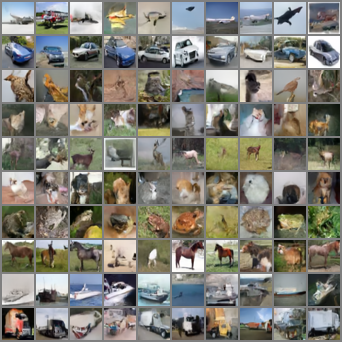

In [12]:
# Train.
for epoch in range(start_epoch, num_epochs):
    utils.print_separator(text='Epoch: {} / {}'.format(epoch + 1, num_epochs))
    
    # Evaluating.
    model.eval()
    with torch.no_grad():
        with torch.random.fork_rng():
            torch.manual_seed(seed)
            rng = torch.quasirandom.SobolEngine(1, scramble=True)
            for (x, y) in tqdm(test_loader, desc='test'):
                x = x.to(device)
                y = y.to(device)
                
                loss = diffusion_loss(model, x, y)
                performance_dict['test_loss'].update_state(loss.item())
                
    # Training.
    model.train()
    for (x, y) in tqdm(train_loader, desc='train'):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        # Calculate loss.
        loss = diffusion_loss(model, x, y)
        performance_dict['train_loss'].update_state(loss.item())
        
        # Do the optimizer step and EMA update.
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        grad_scaler.update()
        
    # Save and print performance.
    for key in metric_keys:
        performance_log[key].append(performance_dict[key].result())
        performance_dict[key].reset_state()
        print(key, ': ',  performance_log[key][-1])
        
    if (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, 'e_{}.pth'.format(str(epoch + 1).zfill(3))))
        img_path = os.path.join(save_dir, 'demo_{}.png'.format(str(epoch + 1).zfill(3)))
        demo(model, img_path, timesteps, eta)
        clear_output(wait=True)
        
    ckpt_bundle = {
        'model': model.state_dict(),
        'model_ema': model_ema.state_dict(),
        'optimizer': optimizer.state_dict(),
        'grad_scaler': grad_scaler.state_dict(),
    }
    torch.save(ckpt_bundle, ckpt_path)
    utils.save_pickle(log_path, performance_log)

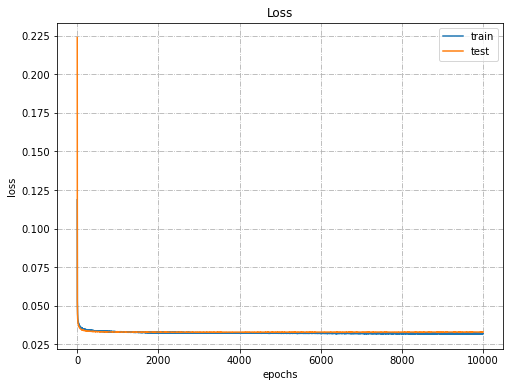

In [13]:
# Plot training history.
performance_log = utils.load_pickle(log_path)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['labels'] = ['train', 'test']
loss_plot_config['attributes'] = ['train_loss', 'test_loss']
utils.save_history_plot(performance_log, loss_plot_config)

In [14]:
# Reload saved model for generation.
# model = DiffusionModel().to(device)
# model_ema = deepcopy(model)

# save_bundle = torch.load(os.path.join(save_dir, 'e_{}.pth'.format(str(5).zfill(3))))
# model.load_state_dict(save_bundle['model'])
# model_ema.load_state_dict(save_bundle['model_ema'])

In [15]:
# Reload saved model for generation.
model = DiffusionModel().to(device)
model.load_state_dict(torch.load(os.path.join(save_dir, 'e_{}.pth'.format('10000'.zfill(3)))))

<All keys matched successfully>

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 112.18it/s]


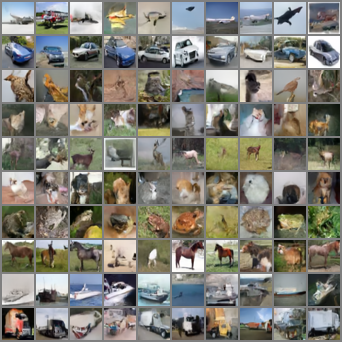

In [16]:
# Generate and save image.
img_path = os.path.join(save_dir, 'demo_final.png')
demo(model, img_path, timesteps, eta)

In [17]:
# Generate and save image.
# img_path = os.path.join(save_dir, 'demo_final.png')
# demo(model_ema, img_path, timesteps, eta)